Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


Using TensorFlow backend.


Loading data...
Wind Train data dim.   (samples x lag x parameters) (42022, 10, 10)
Wind Train labels dim. (samples x lag x parameters) (42022,)
Wind Valid dim.        (samples x lag x parameters) (10485, 10, 10)
Wind Valid labels dim. (samples x lag x parameters) (10485,)
Wind Train images dim.   (samples x lag x parameters x channels) (42022, 32, 32, 3)
74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 15.0033 - mae: 1.2458 - mse: 15.0033
Epoch 00001: val_loss improved from inf to 0.94161, saving model to ./models/H18/best_DenseNet201_tuning.hdf5
329/329 [==============================] - 21s 64ms/step - loss: 15.0033 - mae: 1.2458 - mse: 15.0033 - val_loss: 0.9416 - val_mae: 0.7283 - val_mse: 0.9416 - lr: 0.0010
Epoch 2/100
328/329 [============================>.] - ETA: 0s - loss: 0.8042 - mae: 0.6335 - mse: 0.8042
Epoch 00002: val_loss improved from 0.94161 to 0.90668, saving model to ./models/H1

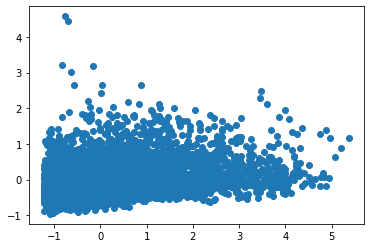

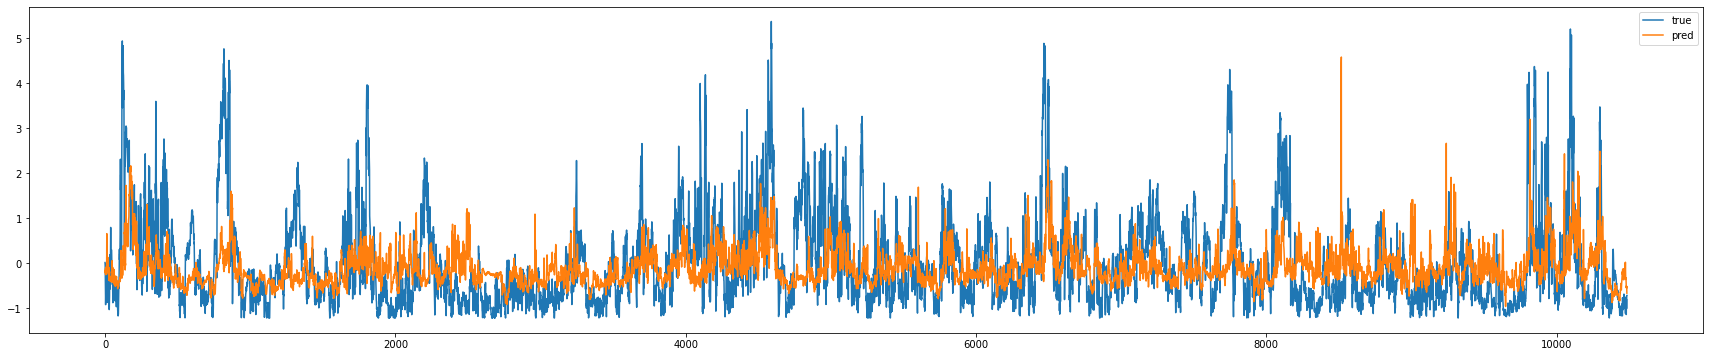

In [1]:

from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/Colab\ Notebooks\

# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.applications.mobilenet_v2  import MobileNetV2
# from tensorflow.keras.applications.nasnet import NASNetLarge 
# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet import ResNet101
# from tensorflow.keras.applications.resnet import ResNet152
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# from tensorflow.keras.applications.resnet_v2 import ResNet101V2
# from tensorflow.keras.applications.resnet_v2 import ResNet152V2
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2	
# from tensorflow.keras.applications.mobilenet import MobileNet
# from tensorflow.keras.applications.densenet import DenseNet121
# from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import DenseNet201
# from tensorflow.keras.applications.resnet import NASNetMobile
# from tensorflow.keras.applications.resnet import NASNetLarge
# from tensorflow.keras.applications.resnet import EfficientNetB0
# from tensorflow.keras.applications.resnet import EfficientNetB1
# from tensorflow.keras.applications.resnet import EfficientNetB2
# from tensorflow.keras.applications.resnet import EfficientNetB3
# from tensorflow.keras.applications.resnet import EfficientNetB4
# from tensorflow.keras.applications.resnet import EfficientNetB5
# from tensorflow.keras.applications.resnet import EfficientNetB6
# from tensorflow.keras.applications.resnet import EfficientNetB7
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop 
# !pip install keras-adamw
# from keras_adamw import AdamW
import os
from sklearn.utils import shuffle
from keras.utils import np_utils
import scipy.io as sio

# filename = 'NASNetLarge_tuning' 
# filename = 'Xception_tuning'
# filename = 'mobilenetV2_tuning'
# filename = 'ResNet50_tuning'
# filename = 'ResNet101_tuning'
# filename = 'ResNet152_tuning'
# filename = 'ResNet50V2_tuning' 
# filename = 'ResNet101V2_tuning' 
# filename = 'ResNet152V2_tuning' 
# filename = 'InceptionV3_tuning' 
# filename = 'InceptionResNetV2_tuning' 
# filename = 'MobileNet_tuning' 
# filename = 'DenseNet121_tuning' 
# filename = 'DenseNet169_tuning' 
filename = 'DenseNet201_tuning' 
#=============================================================================
print('Loading data...')
ExType = 'H18'
DataPath = './wind_data/Norm_Train_Val_data_Lag10_'+ExType+'.mat'   
train_data = sio.loadmat(DataPath)['XTrain']#[...,np.newaxis]
train_labels = sio.loadmat(DataPath)['YTrain']
train_labels = np.squeeze(train_labels)
valid_data = sio.loadmat(DataPath)['XVal']#[...,np.newaxis]
valid_labels = sio.loadmat(DataPath)['YVal']
valid_labels = np.squeeze(valid_labels)

print('Wind Train data dim.   (samples x lag x parameters)',train_data.shape)
print('Wind Train labels dim. (samples x lag x parameters)',train_labels.shape)
print('Wind Valid dim.        (samples x lag x parameters)',valid_data.shape)
print('Wind Valid labels dim. (samples x lag x parameters)',valid_labels.shape)

# data resizing
resizeTo = 32
from tensorflow.keras.preprocessing.image import array_to_img
train_images = np.zeros((train_data.shape[0],resizeTo,resizeTo))
for i, im in enumerate(train_data):
  a = array_to_img(train_data[i,:, :, np.newaxis])
  train_images[i,...] = np.array(a.resize((resizeTo,resizeTo)))
valid_images = np.zeros((valid_data.shape[0],resizeTo,resizeTo))
for i, im in enumerate(valid_data):
  a = array_to_img(valid_data[i,:, :, np.newaxis])
  valid_images[i,...] = np.array(a.resize((resizeTo,resizeTo)))


# duplicate the data three times to look like rgb image
train_data = np.repeat(train_images[:, :, :, np.newaxis], 3, axis=3)
valid_data = np.repeat(valid_images[:, :, :, np.newaxis], 3, axis=3)
print('Wind Train images dim.   (samples x lag x parameters x channels)',train_data.shape)
#=============================================================================
    

base_model = DenseNet201(weights='imagenet', include_top=False,
                      input_tensor=Input(shape=(train_data.shape[1],train_data.shape[2],3)))# new input shape 


noLayers = len(base_model.layers)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
# x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='linear')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers[:noLayers]:
#     layer.trainable = False

#second: fine tune all layers with small learning rate
# Unfreeze the base model
base_model.trainable = False
# print(model.summary())
# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=1e-03, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-06, amsgrad=False)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-07)
# optimizer = AdamW(lr=1e-4, model=model)
model.compile(optimizer=optimizer, loss='mse',metrics=['mae','mse'])

saveTo = './models/'+ExType
if not os.path.exists(saveTo):
    os.makedirs(saveTo)
    
callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, 
            verbose=1, mode='auto', min_delta=0.0005, min_lr=1e-07),#0.0001
            EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto'),
            ModelCheckpoint(saveTo + '/best_'+filename+'.hdf5', monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='auto')]

model.fit(train_data,train_labels,
          batch_size=128,
          epochs=100,
          shuffle=True,
          validation_data=(valid_data,valid_labels),
          verbose=1,
          callbacks=callbacks)
# Testing
# from sklearn.metrics import confusion_matrix
# import sklearn.metrics as skm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

predictions = model.predict(valid_data,verbose=1)
# MAPE = np.mean(100*2.0 * np.abs(valid_labels - predictions) / (np.abs(valid_labels) + np.abs(predictions))).item()
MAPE = np.mean(np.abs((valid_labels - predictions) / valid_labels)) * 100
print("MAE {:.4}, MSE {:.4f}, RMSE {:.4f}, MAPE {:.4f}".format(
    mean_absolute_error(valid_labels, predictions),
    mean_squared_error(valid_labels, predictions),
    sqrt(mean_squared_error(valid_labels, predictions)),
    MAPE))
plt.scatter(valid_labels,predictions)
plt.figure(figsize=(30,6)); 
plt.plot(valid_labels, label='true')
plt.plot(predictions, label='pred')
plt.legend()